In [1]:
#optional, should not run this cell while debugging
import warnings
warnings.filterwarnings('ignore')

In [2]:
#imports
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, \
                         get_linear_schedule_with_warmup, GPT2Config,\
                         GPT2ForSequenceClassification, GPT2Tokenizer #The example below only uses gpt2
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#hyperparamters
batch_size = 16
model_name = 'gpt2'
name_of_last_layer = "score.weight" #specific for each selected trained model
epochs = 2
lr = 2e-5 #generally, smaller learning rates are needed with pretrained models
dec_lr_const = 2 #Used to change the rate at which the lr vanishes - see scheduler initialization
num_labels = 2 #binary classification
dataset_path = 'mental-health.csv' #should contain path to the mental-health dataset

In [4]:
#load model configuration
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name, num_labels=num_labels)

#load tokenizer and set padding config
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

#load pretrained model
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name, config=model_config)

#resize and fix padding
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def parse_mental_health_dataset(path):
    """
    Parses the mental health dataset which should be in a CSV file.

    This function reads a CSV file containing the texts and their corresponding labels ('depression' or 'SuicideWatch').
    It converts the textual labels into binary labels where 'depression' is mapped to 0 and 'SuicideWatch' is mapped to 1.
    The function returns two lists: one with the texts and another with the corresponding binary labels.

    Parameters:
    - path (str): The file path to the CSV file containing the dataset. The CSV is expected to have at least two columns: 'text' and 'label'.

    Returns:
    - texts (list of str): A list containing the text of each post or comment from the dataset.
    - labels (list of int): A list containing the corresponding binary label for each text, where 0 represents 'depression' and 1 represents 'SuicideWatch'.

    Example usage:
    >>> texts, labels = parse_mental_health_dataset('mental_health_data.csv')
    >>> print(texts[0])  # Prints the first text
    >>> print(labels[0])  # Prints the first label (0 or 1)
    """

    # Read the CSV file into a pandas DataFrame
    data = pd.read_csv(path)

    # Extract texts and labels as lists
    texts = data['text'].tolist()
    labels = data['label'].tolist()

    # Define a mapping from textual labels to binary labels
    labels_map = {'depression': 0, 'SuicideWatch': 1}

    # Convert textual labels to binary labels using the defined mapping
    labels = [labels_map[label] for label in labels]

    return texts, labels

In [6]:
def tokenize_data(texts, labels):
    """
    Tokenizes and encodes a list of texts along with their corresponding labels.

    This function takes lists of texts and labels, tokenizes the texts using a predefined tokenizer,
    and encodes them into input IDs and attention masks suitable for model training or evaluation.
    The function assumes the use of a tokenizer that follows the `encode_plus` method from the Hugging Face's Transformers library.

    Parameters:
    - texts (list of str): A list of textual inputs to be tokenized and encoded.
    - labels (list of int): A list of integer labels corresponding to each text input.

    Returns:
    - input_ids (torch.Tensor): A tensor containing the encoded input IDs for each text input.
    - attention_masks (torch.Tensor): A tensor containing the attention masks indicating which tokens should be attended to.
    - labels (torch.Tensor): A tensor containing the labels for each text input.

    Example usage:
    >>> texts = ["This is a sample text.", "Another sample text."]
    >>> labels = [0, 1]
    >>> input_ids, attention_masks, labels = tokenize_data(texts, labels)
    >>> print(input_ids.shape)  # Example output: torch.Size([2, 64])
    >>> print(attention_masks.shape)  # Example output: torch.Size([2, 64])
    >>> print(labels)  # Example output: tensor([0, 1])
    """

    # Initialize lists to hold the encoded inputs and labels
    input_ids, attention_masks, labels_list = [], [], []

    # Loop through each text and its corresponding label
    for text, label in zip(texts, labels):
        # Tokenize and encode the text
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=64,  # Pad & truncate all sentences
            pad_to_max_length=True,  # Pad to max length
            return_attention_mask=True,  # Construct attention masks
            return_tensors='pt'  # Return PyTorch tensors
        )

        # Append the encoded inputs to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels_list.append(label)

    # Concatenate the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels_list)

    return input_ids, attention_masks, labels


In [7]:
class MentalHealthDataset(Dataset):
    """
    A custom PyTorch Dataset for the mental health dataset.

    This dataset class is designed to process and tokenize text data for use in NLP models, specifically
    accommodating tasks related to the mental health dataset. It leverages a tokenizer to convert textual
    inputs into tokenized and encoded forms suitable for model training or evaluation.

    Parameters:
    - texts (list of str): A list of text strings, each representing an individual text instance, such as a post or a comment.
    - labels (list of int): A list of integer labels corresponding to each text instance. The labels should be aligned with the 'texts' list.
    - tokenizer: A tokenizer instance capable of tokenizing the texts. This should be from the Hugging Face's Transformers library or any tokenizer that follows a similar interface.
    - max_len (int, optional): The maximum length of the tokenized output. Texts longer than 'max_len' will be truncated. Defaults to 64.

    The dataset returns a dictionary with the following items for each instance:
    - 'text': The original text string.
    - 'input_ids': The tokenized text converted into input IDs.
    - 'attention_mask': The attention mask indicating which tokens should be attended to by the model.
    - 'labels': The label for the text instance, provided as a long tensor.

    Example usage:
    >>> tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    >>> dataset = MentalHealthDataset(texts=['I feel sad', 'I am happy'], labels=[0, 1], tokenizer=tokenizer, max_len=128)
    >>> print(dataset[0])
    {'text': 'I feel sad', 'input_ids': tensor([...]), 'attention_mask': tensor([...]), 'labels': tensor(0)}
    """

    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        """Returns the number of items in the dataset."""
        return len(self.texts)

    def __getitem__(self, idx):
        """Retrieves the Dataset item at the given index and returns it as a dictionary."""
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize and encode the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,  # Pad & truncate all sentences
            padding='max_length',     # Pad to max length
            return_attention_mask=True,  # Construct attention masks
            return_tensors='pt',     # Return PyTorch tensors
            truncation=True,         # Truncate to max_len
        )

        # Return the tokenized and encoded items along with the label
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [8]:
def create_data_loader(texts, labels, tokenizer, batch_size):
    """
    Creates a PyTorch DataLoader for the mental health dataset.

    This function initializes a MentalHealthDataset with the provided texts, labels, and tokenizer,
    and wraps it in a DataLoader to facilitate batch processing during model training or evaluation.

    Parameters:
    - texts (list of str): A list of text strings, where each string is a text instance such as a post or a comment.
    - labels (list of int): A list of integer labels corresponding to each text instance. The length of 'labels' should match the length of 'texts'.
    - tokenizer: The tokenizer instance used to tokenize the texts. This should be compatible with the MentalHealthDataset's expected tokenizer interface.
    - batch_size (int): The number of items to be included in each batch returned by the DataLoader.

    Returns:
    - A PyTorch DataLoader instance that yields batches of data in the form of dictionaries containing 'input_ids', 'attention_mask', and 'labels' tensors.

    Example usage:
    >>> tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    >>> texts = ["This is the first text.", "Here is another one."]
    >>> labels = [0, 1]  # Assuming binary classification
    >>> batch_size = 2
    >>> data_loader = create_data_loader(texts, labels, tokenizer, batch_size)
    >>> for batch in data_loader:
    >>>     print(batch)  # Each batch is a dictionary with 'input_ids', 'attention_mask', and 'labels'
    """

    # Initialize the MentalHealthDataset with the provided data and tokenizer
    ds = MentalHealthDataset(texts=texts, labels=labels, tokenizer=tokenizer)

    # Create and return the DataLoader
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4,  # Number of subprocesses to use for data loading
        shuffle=True    # Added shuffle for randomizing the data order, which is often beneficial for training
    )


In [17]:
def evaluate(model, data_loader):
    """
    Evaluates the given model's performance on the provided data_loader.

    This function calculates the average loss and accuracy of the model on the dataset wrapped by the data_loader.
    It iterates through the data_loader, feeding batches to the model and accumulating the total loss and number of correct predictions.

    Parameters:
    - model: The model to be evaluated. The model should be a PyTorch model.
    - data_loader: A DataLoader instance that provides batches of data from the evaluation dataset.
                   Each batch is expected to be a dictionary containing 'input_ids', 'attention_mask', and 'labels'.

    The function sets the model to evaluation mode, disables gradient calculations, computes the loss and accuracy
    for each batch, and aggregates these to compute the overall average loss and accuracy.

    Returns:
    - avg_accuracy (float): The average accuracy of the model on the dataset, expressed as a fraction of correct predictions.

    Note: The function assumes that the model, data_loader, and tensors within the data_loader are all on the correct device
    (e.g., CPU or CUDA). Ensure to move the model and tensors to the appropriate device before calling this function.

    Example usage:
    >>> model = MyModel()
    >>> data_loader = DataLoader(my_dataset, batch_size=32)
    >>> avg_accuracy = evaluate(model, data_loader)
    >>> print(f'Average accuracy: {avg_accuracy:.4f}')
    """

    model.eval()  # Set the model to evaluation mode

    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in data_loader:
        # Move tensors to the appropriate device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Disable gradient calculation for evaluation
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Accumulate loss
        loss = outputs.loss
        total_eval_loss += loss.item()

        # Compute accuracy
        logits = outputs.logits  # Extract logits from the model's output
        predictions = torch.argmax(logits, dim=-1)  # Convert logits to predicted class indices
        correct_predictions = torch.sum(predictions == labels)  # Count correct predictions
        total_eval_accuracy += correct_predictions

    # Calculate average loss and accuracy
    avg_loss = total_eval_loss / len(data_loader)
    avg_accuracy = total_eval_accuracy.double() / len(data_loader.dataset)

    return avg_accuracy.item()  # Return average accuracy as a float


In [18]:
def train(model, train_data_loader, test_data_loader, optimizer, scheduler, device, epochs, batch_size):
    """
    Trains the model on the training dataset.

    Parameters:
    - model: The model to be trained.
    - train_data_loader: DataLoader for the training data.
    - test_data_loader: DataLoader for the test data.
    - optimizer: Optimizer used for training.
    - scheduler: Learning rate scheduler.
    - device: The device to run the training on ('cpu' or 'cuda').
    - epochs: The number of epochs to train for.
    - batch_size: The batch size used for training.

    Returns:
    - train_loss: List of average training losses per epoch.
    - train_acc: List of average training accuracies per epoch.
    - test_acc: List of test accuracies after each epoch.
    """

    train_loss = []
    train_acc = []
    test_acc = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_correct_predictions = 0
        total_predictions = 0

        for batch_id, batch in enumerate(train_data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions = torch.sum(predictions == labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            total_correct_predictions += correct_predictions.item()
            total_predictions += labels.size(0)

            if batch_id % 100 == 0 and batch_id > 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f'Epoch {epoch + 1}/{epochs} | Batch [{batch_id+1}/{len(train_data_loader)}] \
                | Train Loss: {loss.item():.4f} | Learning Rate: {current_lr:.6f}')

        avg_train_loss = total_loss / len(train_data_loader)
        avg_train_acc = total_correct_predictions / total_predictions
        train_loss.append(avg_train_loss)
        train_acc.append(avg_train_acc)

        # Evaluate on the test dataset
        test_accuracy = evaluate(model, test_data_loader)
        test_acc.append(test_accuracy)

        print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss} | Train Acc: {avg_train_acc}')

    return train_loss, train_acc, test_acc


In [19]:
#extract data from dataset
texts, labels = parse_mental_health_dataset(dataset_path)
#split to train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2)

In [20]:
#create data loaders
train_data_loader = create_data_loader(train_texts, train_labels, tokenizer, batch_size)
test_data_loader = create_data_loader(test_texts, test_labels, tokenizer, batch_size)

In [21]:
#intialize device and move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [22]:
#train all weights
#intialize training scheduler
optimizer = AdamW(model.parameters(), lr, correct_bias=False)
total_steps = len(train_data_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps * dec_lr_const) #want lr to decrease more slowly

#run train
train_loss, train_acc, test_acc = train(model, train_data_loader, test_data_loader,
                                        optimizer, scheduler, device, epochs, batch_size)

Epoch 1/2 | Batch [101/1019]                 | Train Loss: 0.4863 | Learning Rate: 0.000020
Epoch 1/2 | Batch [201/1019]                 | Train Loss: 0.5620 | Learning Rate: 0.000019
Epoch 1/2 | Batch [301/1019]                 | Train Loss: 0.5324 | Learning Rate: 0.000019
Epoch 1/2 | Batch [401/1019]                 | Train Loss: 0.5707 | Learning Rate: 0.000018
Epoch 1/2 | Batch [501/1019]                 | Train Loss: 0.4628 | Learning Rate: 0.000018
Epoch 1/2 | Batch [601/1019]                 | Train Loss: 0.6121 | Learning Rate: 0.000017
Epoch 1/2 | Batch [701/1019]                 | Train Loss: 0.4718 | Learning Rate: 0.000017
Epoch 1/2 | Batch [801/1019]                 | Train Loss: 0.4051 | Learning Rate: 0.000016
Epoch 1/2 | Batch [901/1019]                 | Train Loss: 0.7213 | Learning Rate: 0.000016
Epoch 1/2 | Batch [1001/1019]                 | Train Loss: 0.7220 | Learning Rate: 0.000015
Epoch 1/2 | Train Loss: 0.5896279680541734 | Train Acc: 0.6834448468479528
Epoc

In [23]:
#train only last layer
#make sure only last layer has grads
param_to_update = []
for name,param in model.named_parameters():
        if name == name_of_last_layer:
          param.requires_grad = True
          param_to_update.append(param)
        else:
          param.requires_grad = False

#intialize optimzer s.t only last layer is updated
optimizer = AdamW(param_to_update, lr, correct_bias=False)
total_steps = len(train_data_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps * dec_lr_const) #want lr to decrease slowly

new_train_loss, new_train_acc, new_test_acc = train(model, train_data_loader, test_data_loader, optimizer, scheduler, device, epochs, batch_size)

train_loss.extend(new_train_loss)
train_acc.extend(new_train_acc)
test_acc.extend(new_test_acc)

Epoch 1/2 | Batch [101/1019]                 | Train Loss: 0.5538 | Learning Rate: 0.000020
Epoch 1/2 | Batch [201/1019]                 | Train Loss: 0.3375 | Learning Rate: 0.000019
Epoch 1/2 | Batch [301/1019]                 | Train Loss: 0.3081 | Learning Rate: 0.000019
Epoch 1/2 | Batch [401/1019]                 | Train Loss: 0.4926 | Learning Rate: 0.000018
Epoch 1/2 | Batch [501/1019]                 | Train Loss: 0.4800 | Learning Rate: 0.000018
Epoch 1/2 | Batch [601/1019]                 | Train Loss: 0.6227 | Learning Rate: 0.000017
Epoch 1/2 | Batch [701/1019]                 | Train Loss: 0.4861 | Learning Rate: 0.000017
Epoch 1/2 | Batch [801/1019]                 | Train Loss: 0.3085 | Learning Rate: 0.000016
Epoch 1/2 | Batch [901/1019]                 | Train Loss: 0.4960 | Learning Rate: 0.000016
Epoch 1/2 | Batch [1001/1019]                 | Train Loss: 0.6849 | Learning Rate: 0.000015
Epoch 1/2 | Train Loss: 0.4475138429351246 | Train Acc: 0.7878583266834448
Epoc

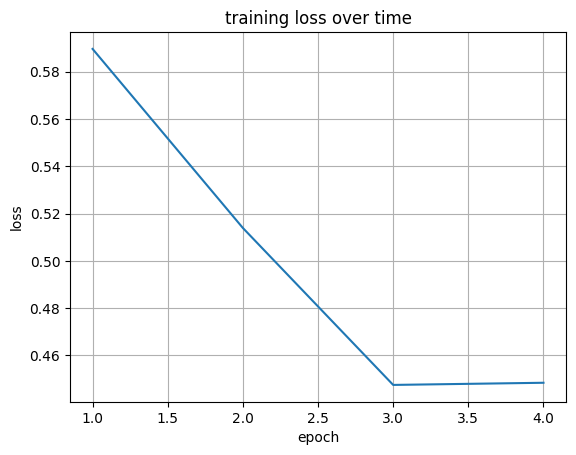

In [39]:
#plot training loss per epoch
plt.plot(range(1, epochs*2 + 1), train_loss)
plt.title("training loss over time")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()

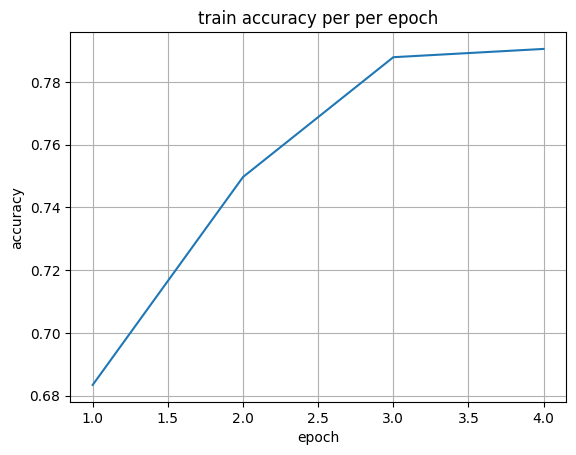

In [42]:
#plot train acc per epoch
plt.plot(range(1, epochs*2 + 1), train_acc)
plt.title("train accuracy per per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid()

In [43]:
print("accuracy on the test set is %.3f" % (test_acc[-1]))

accuracy on the test set is 0.718
